# ****Predictive Analysis of Global Temperatures****
Sahil Chavan, L00151073 - M.Sc. in Computing in Big Data Analytics and Artificial Intelligence, LYIT, Ireland.

## **Scope of the Project**

The model aims to make future climate predictions based on
retrospective climate data. Visualizations will be made using
color gradients. A comparison will be shown against years
and global warm-up with the land temperature scale as the
base.

### **Dataset Used**
We will be using the dataset [Global Temperatures](https://https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) extracted from kaggle.

In [56]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Populating the interactive namespace from numpy and matplotlib


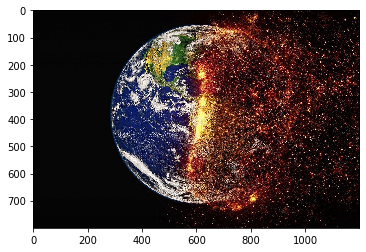

In [57]:

# Read image 

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/drive/My Drive/Technical Project/tempchange.jpg')
imgplot = plt.imshow(img)
plt.show()
  


![tempchange.jpg](attachment:tempchange.jpg)
# Global Temperature Change Prediction

The summer of 2019 turned out pretty hot for Europe. Germany and France
recorded their highest temperatures ever. ”June 28th was the hottest day in French
history, with the town of Gallargues-le-Montueux in southern France clocking the
highest temperature”. The rise in sea levels submerged Venice underwater for
more than a week as the tide rose above its watermark thrice in a week. Due to
the heatwave, wildfires were burning through a national park on the island of Gran
Canaria in Spain. The glacier experienced an acceleration in melting on the Italian
side of Mount Blanc.

Earlier, climate change was only addressed in books or television interviews; now
the population is facing the direct consequences of climate change. As an intelligent
civilization, a plan has to be put in place to tackle the climatic changes happening
so as to be well prepared before the occurrence of any catastrophic event.

After the horrors that happened this year in Australia in 2020, I decided to take a look to the global temperatures and how exactly they have been evolving during the years.

1. What is Climate Change?
    * change in climate patterns
    * very apparent with the start of 20th Century
    * attributed largely to the increased levels of atmospheric carbon dioxide produces by the use of fossil fuels


2. Effects:
    * temperature increase
    * sea level rise (because of massive ice mass loss)
    * shifts in flower's blooming
    * extreme weather events


3. Questions:
    * Did the world temperature increasse?
    * By how much did it increase?
    * Where are the biggest noticeable increases?

## Introduction
Our project aims to predict the yearly temperature change of a given city over a given time period, using an <b>ARIMA model</b> for <b>time series forecasting</b>.

<p>We also aim to plot the temperatures in the cities on a global map with respect to time.</p>


### OBJECTIVE : Predicting shift in temperatures in any given geographical area.
<p>To accomplish this, we used data from the <i><a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data" target="_blank">Global Temperatures</a></i> dataset on Kaggle.</p>

<b>Pre-Processing:</b><br>
<ol>
<li>Converting the 'dt' (date) column to DateTime format</li>
<li>Dropping irrelevant columns and removing rows with NaN values</li>
</ol>
<b>Processing:</b><br>
ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we used the following methods:
<ol>
<li>Plotting the time series to visually check for trend and seasonality</li>
<li>Checking if the histogram of the data fits a Gaussian Curve, and then splitting data into two parts, calculating means and variances and seeing if they vary</li>
<li>Calculating the Augmented Dickey-Fuller Test statistic and using the p-value to determine stationarity</li>
</ol>
If the data was not stationary, we performed <b>differencing</b> to make it stationary.
<br><br>
<b>Fitting the ARIMA model:</b><br>
We performed a grid-search to estimate the best p, q values for the model, for the given data.<br>
We then fit the ARIMA model using the calculated p, q values.
<br><br>
<b>Evaluation:</b><br>
We calculated the <b>Mean Squared Error (MSE)</b> to estimate the performance of the model.

In [0]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
import matplotlib.image as mpimg 
# import chart_studio.plotly as py

In [59]:
! pip install chart_studio

In [60]:
! pip install colorlover

In [0]:
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [0]:
# hide warnings
import warnings
warnings.simplefilter("ignore")
try:
    import seaborn as sns
except:
    ! pip install --user seaborn
    import seaborn as sns

In [0]:
# read the csv file into a DataFrame
df = pd.read_csv("/content/drive/My Drive/Technical Project/GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

# dropping AverageTemperatureUncertainty, Latitude and Longitude and combining City and Country into City
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

# removing all rows with NaN values
df = df.dropna()

# get list of all cities in dataset
cities = set(df.City)

In [0]:
# check stationarity in time series data of a given city

def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    city_df.plot(figsize=(10, 10))
    
    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [65]:
# check stationarity for data of a specific city entered by the user

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=2117, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', '…

In [0]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for New York, United States


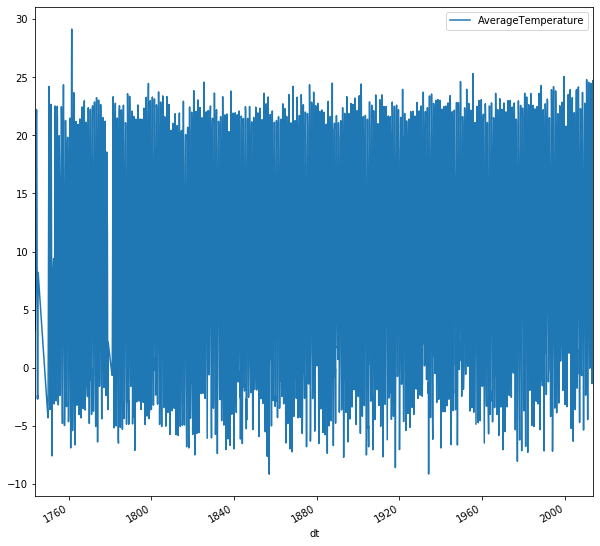

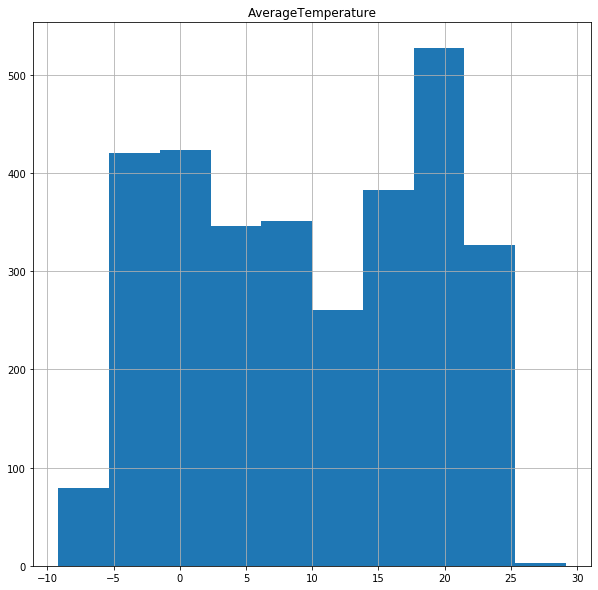

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [18]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

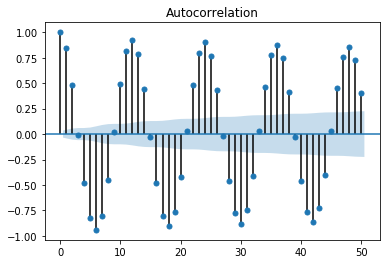

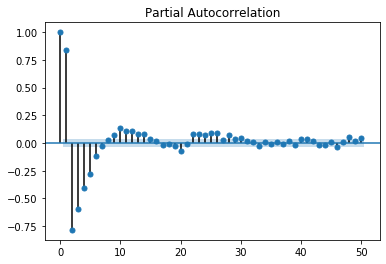

In [19]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [20]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
# To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (2, 2)


In [21]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.678030098594524
Mean Absolute Error: 1.5779966275860358


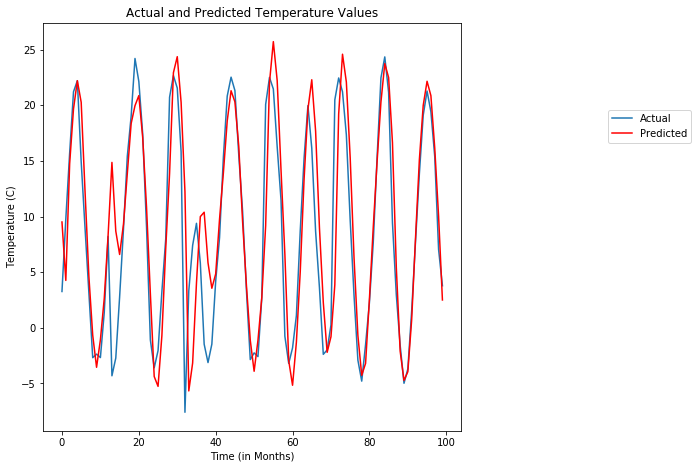

In [22]:
# comparing first 100 predictions with actual values
plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [23]:
# drop-down menu to select number of years for which predictions are required

years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [0]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)[0]  # predictions

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  # excluding predictions for remaining months in current year

In [25]:
# displaying forecasted values for the nth year

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  2.1467135678574594 C
February:  4.259665097037329 C
March:  7.766960227850083 C
April:  11.708584674123848 C
May:  15.017163287242951 C
June:  16.806896393726852 C
July:  16.610590302921693 C
August:  14.50138891672356 C
September:  11.067551505173022 C
October:  7.2485734895658265 C
November:  4.07825495181414 C
December:  2.4049514717777356 C


In [27]:
# plotting the predicted values for the nth year

trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2019+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

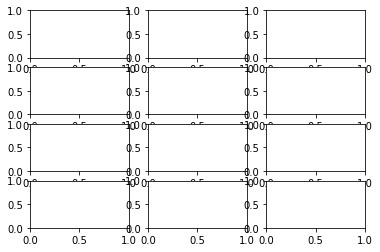

In [28]:
# plotting monthly temperature changes from 2013 to 2013+n years

fig, ax = plt.subplots(nrows=4, ncols=3)

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast[temp]]
        else:
            monthly_change[month].append(out_of_sample_forecast[temp])
        temp+=12

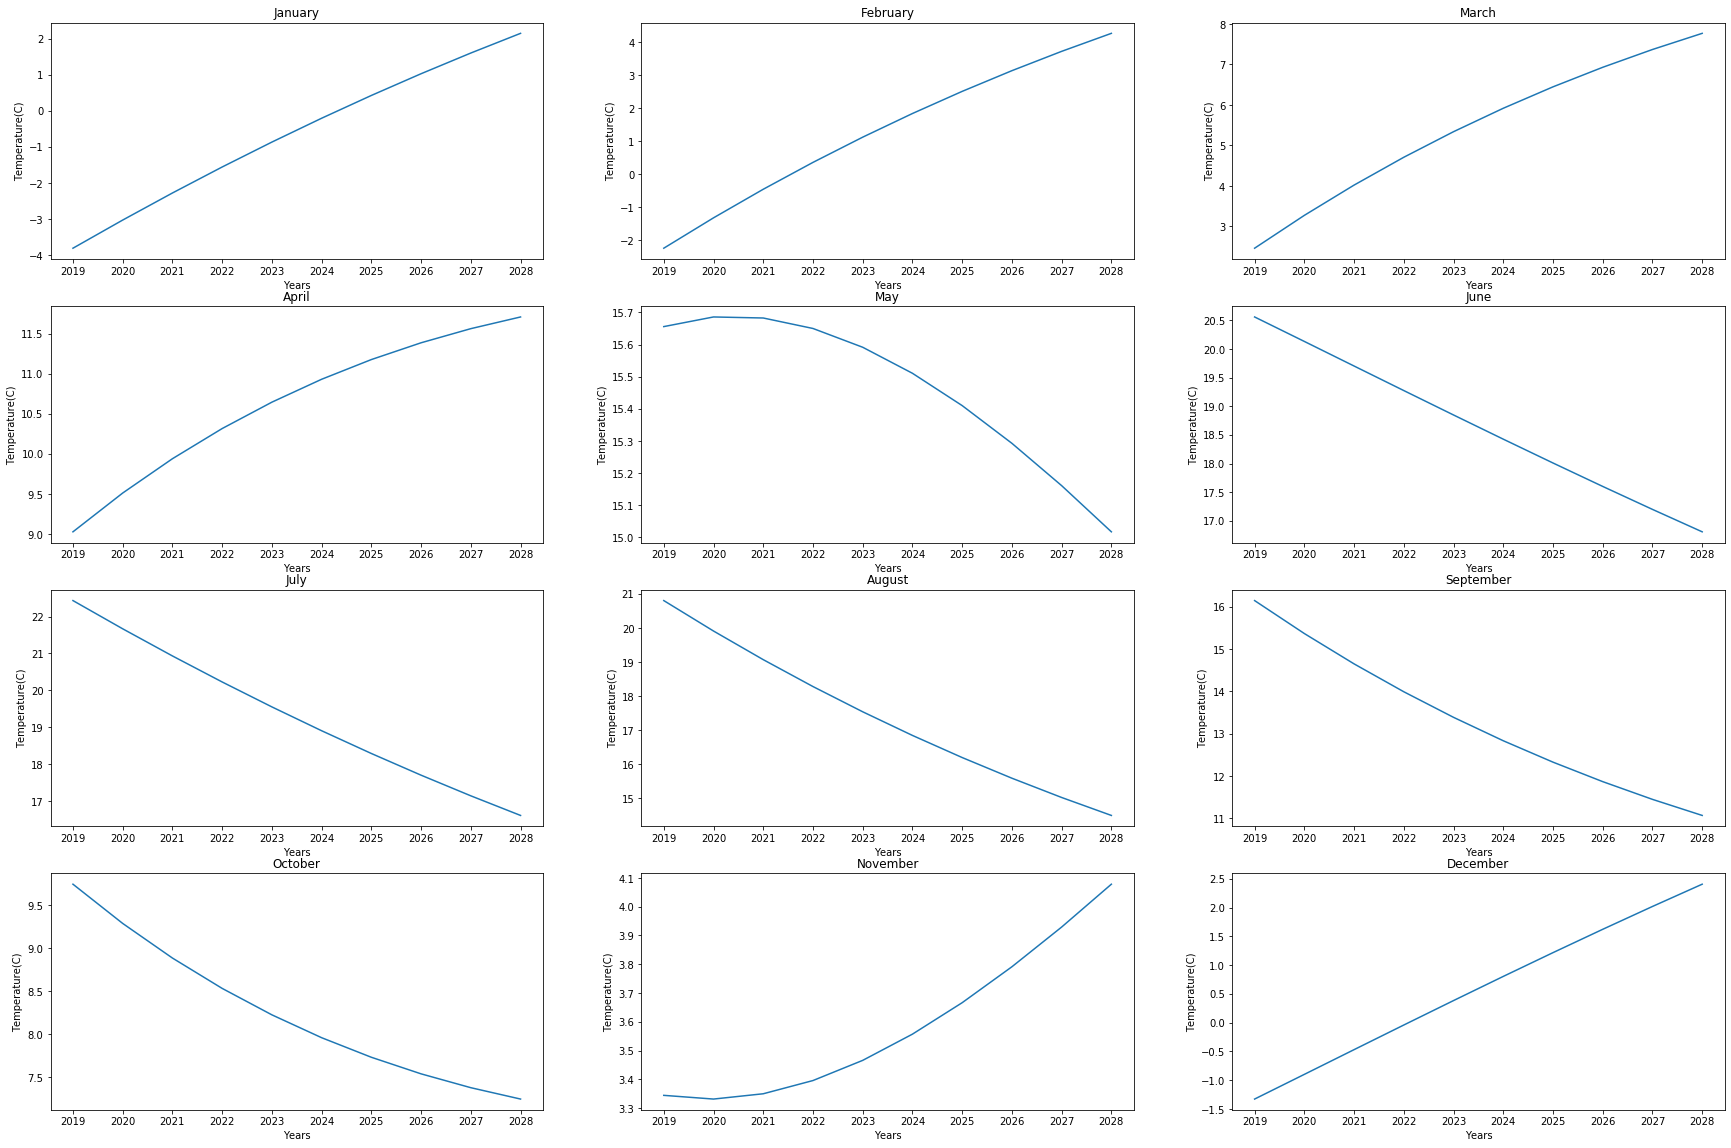

In [30]:
plt.figure(figsize=(30,20))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2019,2019+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()

When we forecasted the future temperature values for the selected city, we could infer from the above plots that there is a noticeable shit in temperatures.<br>
Objective 3 analyzes the factors that might possibly affect temperature change.

# 1. Data on years - overall land and ocean temperature change
1. Reading the data
2. Handling Missing data
3. Create new features (day, month, year etc.)
4. Analysing distribution of data in time to assess how to better analyse the numbers

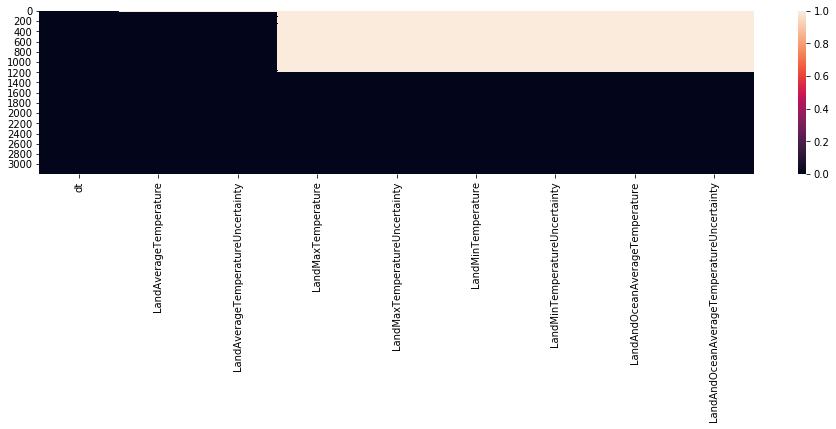

In [31]:
# Read the data
data = pd.read_csv("/content/drive/My Drive/Technical Project/GlobalTemperatures.csv")
data.head(2)

# Make a copy of the data for future graphs
copy = data.copy()

# Missing values
data.isna().sum() # there are 1200 missing values for Max, Min and Land&Ocean Average Temp
plt.figure(figsize = (16, 3))
sns.heatmap(data.isna())

In [32]:
# Missing data with listwise deletion
# Because data is missing in chucks and we are dealing with time series data, we will delete all rows that have at least 
# one missing value.

data.dropna(axis = 0, inplace = True)


# Dealing with the DATE
data['Date'] = pd.to_datetime(data.dt) # converted all dates to the same format

data2 = data.copy() # create a new dataset
data2.drop(columns = ['dt'], axis = 1, inplace = True) # drop the dt column

# Creating new features
data2['day'] = data2['Date'].dt.day
data2['week'] = data2['Date'].dt.week
data2['month'] = data2['Date'].dt.month
data2['year'] = data2['Date'].dt.year

# Week data is not evenly distributed
data2['week'].value_counts() # very uneven information on weeks

# For future analysis, we will work only on yearly data, as average (because there are dates missing and data is not consistent)
earth_data = data2.groupby(by = 'year')[['LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty']].mean().reset_index()

earth_data['turnpoint'] = np.where(earth_data['year'] <= 1975, 'before', 'after') # creating a new columns
earth_data.head(2)

,year,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,turnpoint
0,1850,7.900667,0.876417,13.476667,2.394833,1.964333,1.571167,14.867167,0.308167,before
1,1851,8.178583,0.881917,13.081000,2.397250,2.203917,1.632417,14.991833,0.312083,before


## 1.1 Summary Statistics 1850-2010

Some very simple summary; we have a total of `166` observations. Now we'll go into visualisations, to finally get some insights.

In [33]:
# Simple Summary Statistics
earth_data[['LandAverageTemperature', 'LandMaxTemperature', 
       'LandMinTemperature', 'LandAndOceanAverageTemperature']].describe()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
count,166.000000,166.000000,166.000000,166.000000
mean,8.571583,14.350601,2.743595,15.212566
std,0.473687,0.447741,0.614124,0.298629
min,7.558583,13.081000,1.525083,14.740083
25%,8.195708,14.055917,2.262563,14.991208
50%,8.540750,14.307708,2.734917,15.144208
75%,8.791250,14.539167,3.126833,15.379104
max,9.831000,15.572667,4.148833,16.058583


## 1.2 Plotly

### I. Land Average Temperature from 1750 to 2010
Because we have the data going so back in time only for variable `Land Average Temperature`, I started with it (it would have been a waste not to use is at all, as long as we have it :) )

`Land Average Temperature` had a steady increase: quite flat variation until mid 1800, and then started to increase slowly (when the first **Industrial Revolution** ended, and the effects were starting to show up on the environment). Somewhere in the 1970s the growth started to accelerate. The 1970s mark an increasing trend in **machine automation**, meaning a bust in foreign trading, so the **production started to surge**.

In [34]:
# Creating the dataset - using copy
copy['Date'] = pd.to_datetime(copy.dt)
copy['year'] = copy['Date'].dt.year
land_avg = copy.groupby('year')['LandAverageTemperature', 'LandAverageTemperatureUncertainty'].mean().reset_index()

# Creating the graph
fig = go.Figure()
fig.update_layout(title="Land Average Temperature: 1750-2010", title_font_size = 20,
                  font=dict( family="Courier New, monospace", size=12,color="#7f7f7f"),
                  template = "ggplot2", hovermode= 'closest')
fig.update_xaxes(showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(showline=True, linewidth=1, linecolor='gray')

fig.add_trace(go.Scatter(x = land_avg['year'], y = land_avg['LandAverageTemperature'], mode = 'lines',
                        name = 'Land Avg Temp', marker_color='rgb(128, 0, 0)'))

fig.add_trace(go.Scatter(x = land_avg['year'], y = land_avg['LandAverageTemperatureUncertainty'], mode = 'lines',
                        name = 'Land Avg Temp Error', marker_color = 'rgb(107,142,35)'))

### II. When did Global Warming Started?

The increase on all levels, in both land and ocean almost mirror one another. No doubt the Industrial Revolution had an effect between 1900 and 1975, but combining with the **population increase** that started to surge somewhere in 1975 (from ~2.5 bil in 1950 to 5 bil in 2000) created a much bigger **negative contribution** to the overall global warming state. 

In [35]:
# Figure layout
fig = make_subplots(rows=2, cols=2, insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}])
fig.update_layout(title="When Global Warming Started?",font=dict( family="Courier New, monospace", size=12,color="#7f7f7f"),
                 template = "ggplot2", title_font_size = 20, hovermode= 'closest')
fig.update_xaxes(showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(showline=True, linewidth=1, linecolor='gray')

# Figure data
fig.add_trace(go.Scatter(x = earth_data['year'], y = earth_data['LandAverageTemperature'], mode = 'lines',
                        name = 'Land Avg Temp', marker_color='rgb(128, 0, 0)'), row = 1, col = 1)
fig.add_trace(go.Scatter( x=[1975, 1975], y=[7.5, 10], mode="lines",line=go.scatter.Line(color="gray"), showlegend=False),
             row = 1, col = 1)
#=============================================================================
fig.add_trace(go.Scatter(x = earth_data['year'], y = earth_data['LandMinTemperature'], mode = 'lines',
                        name = 'Land Min Temp', marker_color='rgb(210,105,30)'), row = 1, col = 2)
fig.add_trace(go.Scatter( x=[1975, 1975], y=[1.5, 4.5], mode="lines",line=go.scatter.Line(color="gray"), showlegend=False),
             row = 1, col = 2)
#=============================================================================
fig.add_trace(go.Scatter(x = earth_data['year'], y = earth_data['LandMaxTemperature'], mode = 'lines',
                        name = 'Land Max Temp', marker_color='rgb(135,206,235)'), row = 2, col = 1)
fig.add_trace(go.Scatter( x=[1975, 1975], y=[13, 15.5], mode="lines",line=go.scatter.Line(color="gray"), showlegend=False),
             row = 2, col = 1)
#=============================================================================
fig.add_trace(go.Scatter(x = earth_data['year'], y = earth_data['LandAndOceanAverageTemperature'], mode = 'lines',
                        name = 'Land&Ocean Avg Temp', marker_color='rgb(107,142,35)'), row = 2, col = 2)
fig.add_trace(go.Scatter( x=[1975, 1975], y=[14.5, 16], mode="lines",line=go.scatter.Line(color="gray"), showlegend=False),
             row = 2, col = 2)

### III. Change in Average Temperature before/after 1975 - cold is hotter?

I feel like 1975 was a "no turning back" point, so I chose this moment to compare temperatures before and after.

* `Land Average Temperature` - an **increase** from 8.37 degrees to 9.20; almost 1 full grade
* `Land Minimum Temperatures` - an **increase** from 2.45 degrees to 3.64; 1.19 grades increase
* `Land Maximum Temperature` - an **increase** from 14.18 degrees to 14.89; 0.71 grades increase
* `Land and Ocean Average Temperature` - an **increase** from 15.06 degrees to 15.62; 0.56 grades increase

Now.... **WHY? Why is the "Cold Weather" getting hotter more rapidly than the "Hot Weather"?**

No. I am serious. Why? Because I have some theories, but none is a very good one, so I will wait for somebody with a little bit more knowledge on this part to address this.

In [36]:
# Change in average temperature before/after 1975

# Figure layout
fig = make_subplots(rows=2, cols=2, insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}])
fig.update_layout(title="Average Temperatures before and after 1975",font=dict( family="Courier New, monospace", size=12,color="#7f7f7f"),
                 template = "ggplot2", title_font_size = 20, hovermode= 'closest')

# Figure data
fig.add_trace(go.Box(x = earth_data['LandAverageTemperature'], y = earth_data['turnpoint'],boxpoints = 'all',jitter = 0.3, 
                     pointpos = -1.6, marker_color = 'rgb(128, 0, 0)', boxmean = True, name = 'Land Avg Temp'),
             row = 1, col = 1)
fig.add_trace(go.Box(x = earth_data['LandMinTemperature'], y = earth_data['turnpoint'],boxpoints = 'all',jitter = 0.3, 
                     pointpos = -1.6, marker_color = 'rgb(210,105,30)', boxmean = True, name = 'Land Min Temp'),
             row = 1, col = 2)
fig.add_trace(go.Box(x = earth_data['LandMaxTemperature'], y = earth_data['turnpoint'],boxpoints = 'all',jitter = 0.3, 
                     pointpos = -1.6, marker_color = 'rgb(135,206,235)', boxmean = True, name = 'Land Max Temp'),
             row = 2, col = 1)
fig.add_trace(go.Box(x = earth_data['LandAndOceanAverageTemperature'], y = earth_data['turnpoint'], boxpoints = 'all',jitter = 0.3, 
                     pointpos = -1.6, marker_color = 'rgb(107,142,35)', boxmean = True, name = 'Land&Ocean Avg Temp'),
             row = 2, col = 2)


fig.update_traces(orientation='h')

In [0]:
# Read the file (countries + cities)
countries = pd.read_csv("/content/drive/My Drive/Technical Project/GlobalLandTemperaturesByCity.csv")

# Because the file is very big and there are many dates missing (like the last file), we will group by year
# create column year
countries['Date'] = pd.to_datetime(countries['dt'])
countries['year'] = countries['Date'].dt.year

# Group by year
by_year = countries.groupby(by = ['year', 'City', 'Country', 'Latitude', 'Longitude']).mean().reset_index()

# Append the continent & iso codes
continent_map = pd.read_csv("/content/drive/My Drive/Technical Project/continents2.csv")
continent_map['Country'] = continent_map['name']
continent_map = continent_map[['Country', 'region', 'alpha-2', 'alpha-3']]

# Add information
data = pd.merge(left = by_year, right = continent_map, on = 'Country', how = 'left')

# Filter starting 1825 - because some countries weren't monitored before this year on some periods, 
# the mean overall could be quite misleading (example: Americas have an increase from 1821 to 1825 of 5 points in temperature,
# but this happens only because in 1824 data for South America started to be collected)
data = data[data['year'] >= 1825]

# Datasets:

region = data.dropna(axis = 0).groupby(by = ['region', 'year']).mean().reset_index()
countries = data.dropna(axis = 0).groupby(by = ['region', 'Country', 'year']).mean().reset_index()
cities = data.dropna(axis = 0).groupby(by = ['region', 'Country', 'City', 'year', 'Latitude', 'Longitude']).mean().reset_index()

## 2.1 Plotly

### I. Continents Increase in Average Temperature
There are some variations at the beginning of the period, mainly due to a fluctuation in the gathering of data (there are some countries where there is info in some years and some years there is not).

Anyhow, all continents look to have increased in `Temperature` in about the same pace.

In [40]:
# Figure layout
fig = make_subplots(rows=1, cols=2, insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}])
fig.update_layout(title="Continents increase in Average Temperature", title_font_size = 20,
                  font=dict( family="Courier New, monospace", size=12,color="#7f7f7f"),
                  template = "ggplot2", hovermode= 'closest')
fig.update_xaxes(showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(showline=True, linewidth=1, linecolor='gray')

#============================= Scatter =============================
fig.add_trace(go.Scatter(x = region[region['region'] == 'Europe']['year'], y = region[region['region'] == 'Europe']['AverageTemperature'], mode = 'lines',
                        name = 'Europe', marker_color='rgb(128, 0, 0)'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = region[region['region'] == 'Americas']['year'], y = region[region['region'] == 'Americas']['AverageTemperature'], mode = 'lines',
                        name = 'Americas', marker_color='rgb(210,105,30)'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = region[region['region'] == 'Asia']['year'], y = region[region['region'] == 'Asia']['AverageTemperature'], mode = 'lines',
                        name = 'Asia', marker_color='rgb(135,206,235)'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = region[region['region'] == 'Africa']['year'], y = region[region['region'] == 'Africa']['AverageTemperature'], mode = 'lines',
                        name = 'Africa', marker_color='rgb(107,142,35)'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = region[region['region'] == 'Oceania']['year'], y = region[region['region'] == 'Oceania']['AverageTemperature'], mode = 'lines',
                        name = 'Oceania', marker_color='rgb(70,130,180)'), row = 1, col = 1)

#============================= Bar =============================
y1 = np.round(region.groupby(by = 'region')['AverageTemperature'].mean().tolist(), 1)
y2 = np.round(region.groupby(by = 'region')['AverageTemperature'].max().tolist(), 1)

fig.add_trace(go.Bar(x = region['region'].unique(), y = region.groupby(by = 'region')['AverageTemperature'].mean().tolist(), 
                     name = 'Mean Temp', marker_color = 'rgb(188,143,143)', text = y1, textposition = 'auto'),
              row = 1, col = 2)
fig.add_trace(go.Bar(x = region['region'].unique(), y = region.groupby(by = 'region')['AverageTemperature'].max().tolist(), 
                     name = 'Max Temp', marker_color = 'rgb(222,184,135)', text = y2, textposition = 'auto'),
              row = 1, col = 2)

### II. Countries rank - from the biggest to smallest increase in temperature since 1825

Now, this is interesting:
* **Brazil and Argentina** - BIG deforestation issues (their wildfires have increased big time and the agriculture is the main factor)
* **Kazakhstan** - place for testing biological and nuclear weapons by the soviets. Also, here are located the most polluting industries. Most of their water is infected by industrial and agricultural runoff and it is in some places radioactivity. (http://factsanddetails.com/central-asia/Kazakhstan/sub8_4f/entry-4681.html)
* **Turkmenistan** - Desertification and drying of the Aral Sea, due to HEAVY agricultural practices. (https://en.wikipedia.org/wiki/Environmental_issues_in_Turkmenistan)
* **Nepal** - Air Pollution. 1 in 10 Nepalese suffer from chronic lung problem, and the life expectancy of a new born is shorter by 2 years due solely to problems air quality related. (https://www.nepalitimes.com/here-now/air-pollution-is-more-dangerous-than-smoking/)

In [41]:
# Data
mean = countries.groupby(['Country', 'region'])['AverageTemperature'].mean().reset_index()
maximum = countries.groupby(['Country', 'region'])['AverageTemperature'].max().reset_index()

difference = pd.merge(left = mean, right = maximum, on = ['Country', 'region'])
difference['diff'] = difference['AverageTemperature_y'] - difference['AverageTemperature_x']

# Graph
fig = go.Figure()
fig.update_layout(title="Difference in Temperature (Countries)", title_font_size = 20,
                  font=dict( family="Courier New, monospace", size=13,color="#7f7f7f"),
                  template = "ggplot2", autosize = False, height = 3500, width = 750)
fig.update_xaxes(showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(showline=True, linewidth=1, linecolor='gray')

sort_diff = difference[['Country', 'region', 'diff']].sort_values(by = 'diff', ascending = True)
fig.add_trace(go.Bar(x = sort_diff['diff'], y = sort_diff['Country'], orientation = 'h',
                    marker=dict(color='rgb(222,184,135)', line=dict( color='rgb(188,143,143)', width=0.6))))
fig.show()

## 2.2 Plotly Maps

### I. Interactive Globe Map - Temperature increase over the years

First years have some fluctuations due to absence of data for some nations, but the biggest increases are visible in Europe, South America and West Asia.

In [42]:
# Data - we need iso alpha-3 codes
map_countries = data.dropna(axis = 0).groupby(by = ['region', 'Country', 'year','alpha-3']).mean().reset_index()

# Min temperature is -5.453083, and because the size in a map cannot be negative, we will add 6 to all temperatures
# to "standardize the data"
map_countries['AverageTemperature'] = map_countries['AverageTemperature'] + 6

fig = px.scatter_geo(map_countries, locations='alpha-3', color='region',
                     color_discrete_sequence = ('rgb(128,0,0)','rgb(210,105,30)','rgb(135,206,235)','rgb(107,142,35)'),
                     hover_name="Country", size="AverageTemperature", size_max=15, opacity = 0.8,
                     animation_frame="year",
                     projection="natural earth", title='Interactive Globe Map - Temperature increase')
fig.show()

### II. Globe Map - difference between the mean and maximum temperature

* the bubbles - `countries`
* the COLOR of the bubbles - the `mean temperature`
* the size of the bubbles - how much the temperature increased?

What do we see? The biggest temperature changes were in Europe and South America.

There is again the question, as we see that more colder countries (situated to the North) had a biggest increase in Temperature than the overall South, why is this happening?


In [43]:
# Calculating the difference column
mean = map_countries.groupby(['region','Country','alpha-3'])['AverageTemperature'].mean().reset_index()
maximum = map_countries.groupby(['region','Country','alpha-3'])['AverageTemperature'].max().reset_index()
difference = pd.merge(left = mean, right = maximum, on = ['region','Country','alpha-3'])
difference['diff'] = difference['AverageTemperature_y'] - difference['AverageTemperature_x']
difference.rename(columns = {'AverageTemperature_y':'Maximum Average Temperature',
                             'AverageTemperature_y':'Overall Avg Temp'}, inplace = True)

# Figure
fig = px.scatter_geo(difference, locations="alpha-3", color="Overall Avg Temp", #we color by average temp
                     hover_name="Country", size="diff", size_max=15, #we size by how big is the difference
                     projection="natural earth", opacity = 0.8,
                     color_continuous_scale=('#283747', '#2874A6', '#3498DB', '#F5B041', '#E67E22', '#A93226'),
                     title = 'Global Map - difference between the mean and max temperatures')
fig.show()

### Conclusion

We have analyzed the dataset and concluded that there is an upward trend in the increase of climate. Since 1875, there is asteady increase and it has hardly gone down. We have cleaned the dataset and pointed out the missing values. Visualizations are created to show the land temperatures actual and predicted values. Evaluation of the model is done by calculating mean square error and mean absolute error. At the very end, we have plotted an interactive global map whhich shows us the retrospective global average temperatures. The second global map shows us the difference in mean and maximum temperatures accross the globe.